In [123]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC Lasso' = '#c994c7', 
#              'HSIC Lasso, B = 50' = '#df65b0',
#              'HSIC Lasso, B = 20' = '#e7298a', 
#              'HSIC Lasso, B = 10' = '#ce1256',
#              'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443',
             'Localized HSIC Lasso, K = 4' = '#abaf1c'
#              'Localized HSIC Lasso, L = 10' = '#1bd145',
#              'Localized HSIC Lasso, L = 15' = '#b70eb7'
            )
methods <- c('HSIC Lasso', 
#              'HSIC Lasso, B = 50',
#              'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
#              'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
#              'HSIC Lasso, B = 5', 
             'mRMR', 'LARS',
             'Localized HSIC Lasso, K = 4'
#              'Localized HSIC Lasso, K = 10',
#              'Localized HSIC Lasso, K = 15'
            )
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('-B=', ', B = ', model),
              model = gsub('-K=', ', K = ', model),
               model = gsub('-M=3', '', model),
               model = gsub('localized_', 'Localized ', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy) / sqrt(ended), accuracy = mean(accuracy) ) %>%
        ungroup %>%
        mutate(label = label)

}

Warning message:
“Removed 9 rows containing missing values (geom_point).”Warning message:
“Removed 9 rows containing missing values (geom_path).”

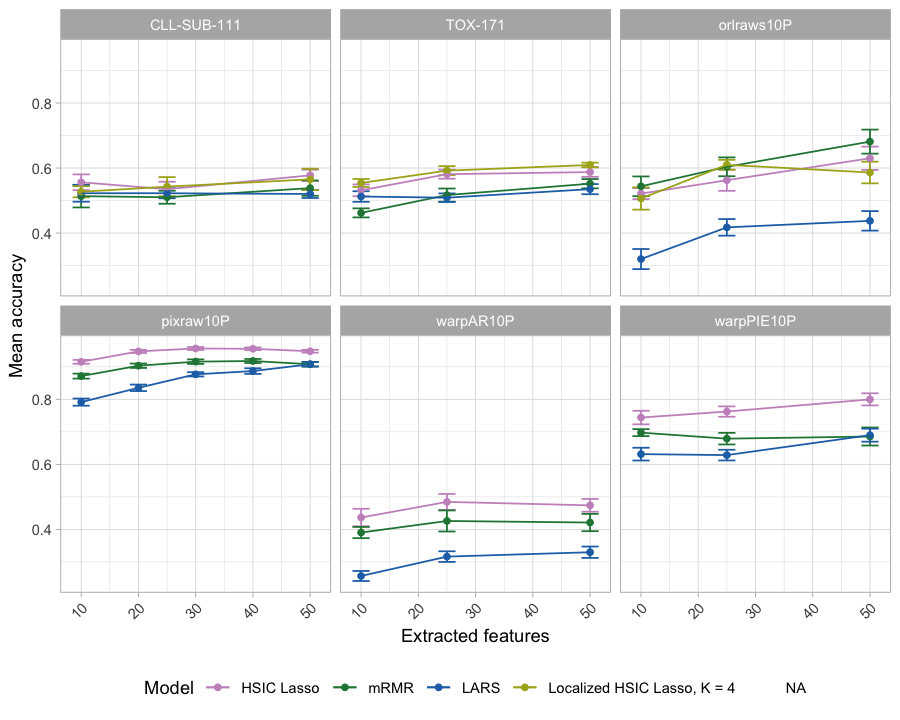

In [124]:
# 20percent
CLLSUB111 <- summarize_benchmark('../results/others_asu_smalltrain/CLL-SUB-111_prediction.tsv') %>%
    filter(! is.na(model))
pixraw10P <- summarize_benchmark('../results/asu/pixraw10P_prediction.tsv') %>%
    filter(! is.na(model))
warpAR10P <- summarize_benchmark('../results/others_asu_smalltrain/warpAR10P_prediction.tsv') %>%
    filter(! is.na(model))
orlraws10P <- summarize_benchmark('../results/others_asu_smalltrain/orlraws10P_prediction.tsv') %>%
    filter(! is.na(model))
warpPIE10P <- summarize_benchmark('../results/others_asu_smalltrain/warpPIE10P_prediction.tsv') %>%
    filter(! is.na(model))
tox171 <- summarize_benchmark('../results/others_asu_smalltrain/TOX-171_prediction.tsv') %>%
    filter(! is.na(model))

CLLSUB111_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain/CLL-SUB-111_prediction.tsv')
pixraw10P_lhsic <- summarize_benchmark('../results/lhl_asu/pixraw10P_prediction.tsv')
warpAR10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain/warpAR10P_prediction.tsv')
orlraws10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain/orlraws10P_prediction.tsv')
warpPIE10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain/warpPIE10P_prediction.tsv')
tox171_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain/TOX-171_prediction.tsv')


CLLSUB111 <- bind_rows(CLLSUB111, CLLSUB111_lhsic)
tox171 <- bind_rows(tox171, tox171_lhsic)
orlraws10P <- bind_rows(orlraws10P, orlraws10P_lhsic)
pixraw10P <- bind_rows(pixraw10P, pixraw10P_lhsic)
warpAR10P <- bind_rows(warpAR10P, warpAR10P_lhsic)
warpPIE10P <- bind_rows(warpPIE10P, warpPIE10P_lhsic)

predictions <- bind_rows(CLLSUB111, pixraw10P, warpAR10P, 
                         orlraws10P, warpPIE10P, tox171) %>%
    mutate(model = factor(model, levels = methods))

options(repr.plot.width=7.5, repr.plot.height=6)
predictions %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        theme_light() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1)) +
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
        scale_color_manual(values = palette) +
        facet_wrap(~label)

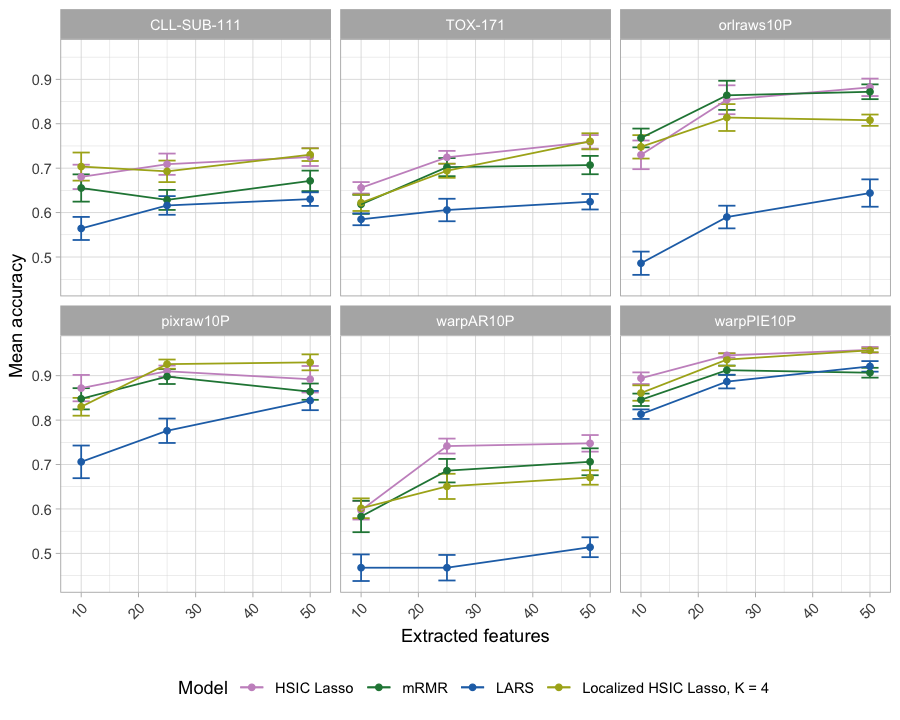

In [125]:
#50 percent
CLLSUB111 <- summarize_benchmark('../results/others_asu_smalltrain_50p/CLL-SUB-111_prediction.tsv') %>%
    filter(! is.na(model))
pixraw10P <- summarize_benchmark('../results/others_asu_smalltrain_50p/pixraw10P_prediction.tsv') %>%
    filter(! is.na(model))
warpAR10P <- summarize_benchmark('../results/others_asu_smalltrain_50p/warpAR10P_prediction.tsv') %>%
    filter(! is.na(model))
orlraws10P <- summarize_benchmark('../results/others_asu_smalltrain_50p/orlraws10P_prediction.tsv') %>%
    filter(! is.na(model))
warpPIE10P <- summarize_benchmark('../results/others_asu_smalltrain_50p/warpPIE10P_prediction.tsv') %>%
    filter(! is.na(model))
tox171 <- summarize_benchmark('../results/others_asu_smalltrain_50p/TOX-171_prediction.tsv') %>%
    filter(! is.na(model))

CLLSUB111_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p/CLL-SUB-111_prediction.tsv')
pixraw10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p/pixraw10P_prediction.tsv')
warpAR10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p/warpAR10P_prediction.tsv')
orlraws10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p/orlraws10P_prediction.tsv')
warpPIE10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p/warpPIE10P_prediction.tsv')
tox171_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p/TOX-171_prediction.tsv')


CLLSUB111 <- bind_rows(CLLSUB111, CLLSUB111_lhsic)
tox171 <- bind_rows(tox171, tox171_lhsic)
orlraws10P <- bind_rows(orlraws10P, orlraws10P_lhsic)
pixraw10P <- bind_rows(pixraw10P, pixraw10P_lhsic)
warpAR10P <- bind_rows(warpAR10P, warpAR10P_lhsic)
warpPIE10P <- bind_rows(warpPIE10P, warpPIE10P_lhsic)

predictions <- bind_rows(CLLSUB111, pixraw10P, warpAR10P, 
                         orlraws10P, warpPIE10P, tox171) %>%
    mutate(model = factor(model, levels = methods))

options(repr.plot.width=7.5, repr.plot.height=6)
predictions %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        theme_light() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1)) +
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
        scale_color_manual(values = palette) +
        facet_wrap(~label)

In [126]:
orlraws10P

model,selected,n,ended,sem,accuracy,label
HSIC Lasso,10,10,10,0.03228347,0.730,orlraws10P
HSIC Lasso,25,10,10,0.03253033,0.854,orlraws10P
HSIC Lasso,50,10,10,0.01965254,0.882,orlraws10P
mRMR,10,10,10,0.02112397,0.768,orlraws10P
mRMR,25,10,10,0.03276855,0.864,orlraws10P
mRMR,50,10,10,0.01665333,0.872,orlraws10P
LARS,10,10,10,0.02617038,0.486,orlraws10P
LARS,25,10,10,0.02551688,0.590,orlraws10P
LARS,50,10,10,0.03081125,0.644,orlraws10P
"Localized HSIC Lasso, K = 4",10,10,10,0.02636496,0.748,orlraws10P


Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_path).”

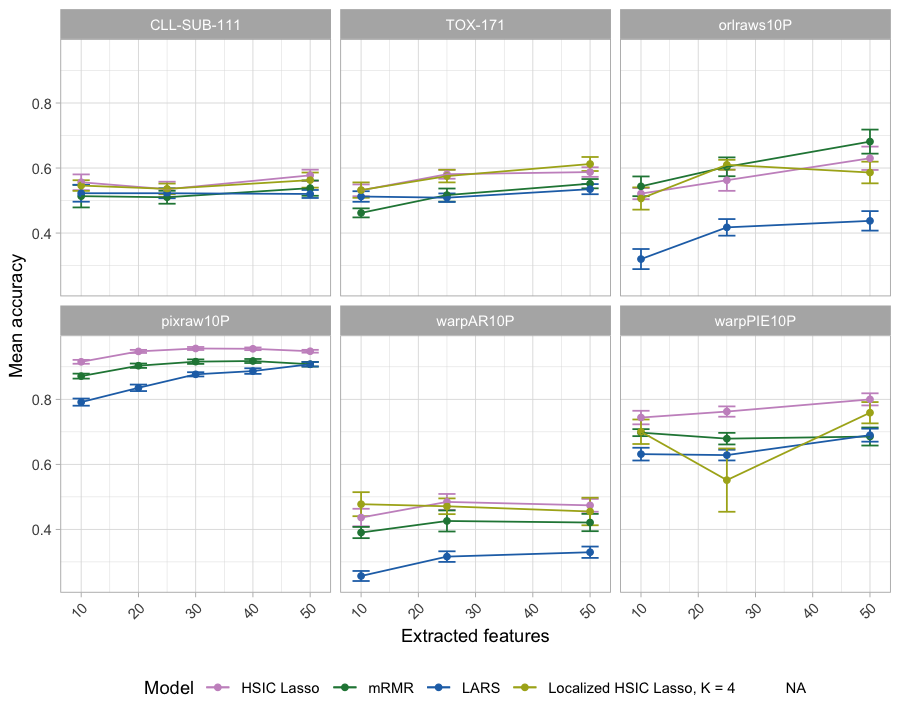

In [128]:
# 20percent + delta decomposition
# data 3 and data 4 got memory error due to large class number 
CLLSUB111 <- summarize_benchmark('../results/others_asu_smalltrain/CLL-SUB-111_prediction.tsv') %>%
    filter(! is.na(model))
pixraw10P <- summarize_benchmark('../results/asu/pixraw10P_prediction.tsv') %>%
    filter(! is.na(model))
warpAR10P <- summarize_benchmark('../results/others_asu_smalltrain/warpAR10P_prediction.tsv') %>%
    filter(! is.na(model))
orlraws10P <- summarize_benchmark('../results/others_asu_smalltrain/orlraws10P_prediction.tsv') %>%
    filter(! is.na(model))
warpPIE10P <- summarize_benchmark('../results/others_asu_smalltrain/warpPIE10P_prediction.tsv') %>%
    filter(! is.na(model))
tox171 <- summarize_benchmark('../results/others_asu_smalltrain/TOX-171_prediction.tsv') %>%
    filter(! is.na(model))

CLLSUB111_lhsic  <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_delta/CLL-SUB-111_prediction.tsv')
tox171_lhsic     <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_delta/TOX-171_prediction.tsv')
orlraws10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain/orlraws10P_prediction.tsv')
pixraw10P_lhsic  <- summarize_benchmark('../results/lhl_asu/pixraw10P_prediction.tsv')
warpAR10P_lhsic  <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_delta/warpAR10P_prediction.tsv')
warpPIE10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_delta/warpPIE10P_prediction.tsv')



CLLSUB111 <- bind_rows(CLLSUB111, CLLSUB111_lhsic)
tox171 <- bind_rows(tox171, tox171_lhsic)
orlraws10P <- bind_rows(orlraws10P, orlraws10P_lhsic)
pixraw10P <- bind_rows(pixraw10P, pixraw10P_lhsic)
warpAR10P <- bind_rows(warpAR10P, warpAR10P_lhsic)
warpPIE10P <- bind_rows(warpPIE10P, warpPIE10P_lhsic)

predictions <- bind_rows(CLLSUB111, pixraw10P, warpAR10P, 
                         orlraws10P, warpPIE10P, tox171) %>%
    mutate(model = factor(model, levels = methods))

options(repr.plot.width=7.5, repr.plot.height=6)
predictions %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        theme_light() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1)) +
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
        scale_color_manual(values = palette) +
        facet_wrap(~label)

In [118]:
warpAR10P

model,selected,n,ended,sem,accuracy,label
HSIC Lasso,10,10,10,0.02690017,0.4365385,warpAR10P
HSIC Lasso,25,10,10,0.02441794,0.4846154,warpAR10P
HSIC Lasso,50,10,10,0.01965609,0.4740385,warpAR10P
mRMR,10,10,10,0.01727204,0.3903846,warpAR10P
mRMR,25,10,10,0.03237179,0.4259615,warpAR10P
mRMR,50,10,10,0.02661608,0.4211538,warpAR10P
LARS,10,10,10,0.01544127,0.2567308,warpAR10P
LARS,25,10,10,0.01630840,0.3163462,warpAR10P
LARS,50,10,10,0.01744073,0.3298077,warpAR10P
NA,10,10,10,0.01996720,0.3971154,warpAR10P


In [152]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC Lasso' = '#c994c7', 
#              'HSIC Lasso, B = 50' = '#df65b0',
#              'HSIC Lasso, B = 20' = '#e7298a', 
#              'HSIC Lasso, B = 10' = '#ce1256',
#              'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443',
             'Localized HSIC Lasso, K = 5, S = 4' = '#abaf1c'
#              'Localized HSIC Lasso, L = 10' = '#1bd145',
#              'Localized HSIC Lasso, L = 15' = '#b70eb7'
            )
methods <- c('HSIC Lasso', 
#              'HSIC Lasso, B = 50',
#              'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
#              'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
#              'HSIC Lasso, B = 5', 
             'mRMR', 'LARS',
             'Localized HSIC Lasso, K = 5, S = 4'
#              'Localized HSIC Lasso, K = 10',
#              'Localized HSIC Lasso, K = 15'
            )
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('-B=', ', B = ', model),
               model = gsub('-K=', ', K = ', model),
               model = gsub('-S=', ', S = ', model),
               model = gsub('-M=3', '', model),
               model = gsub('localized_', 'Localized ', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy) / sqrt(ended), accuracy = mean(accuracy) ) %>%
        ungroup %>%
        mutate(label = label)

}

Warning message:
“Removed 15 rows containing missing values (geom_point).”Warning message:
“Removed 15 rows containing missing values (geom_path).”

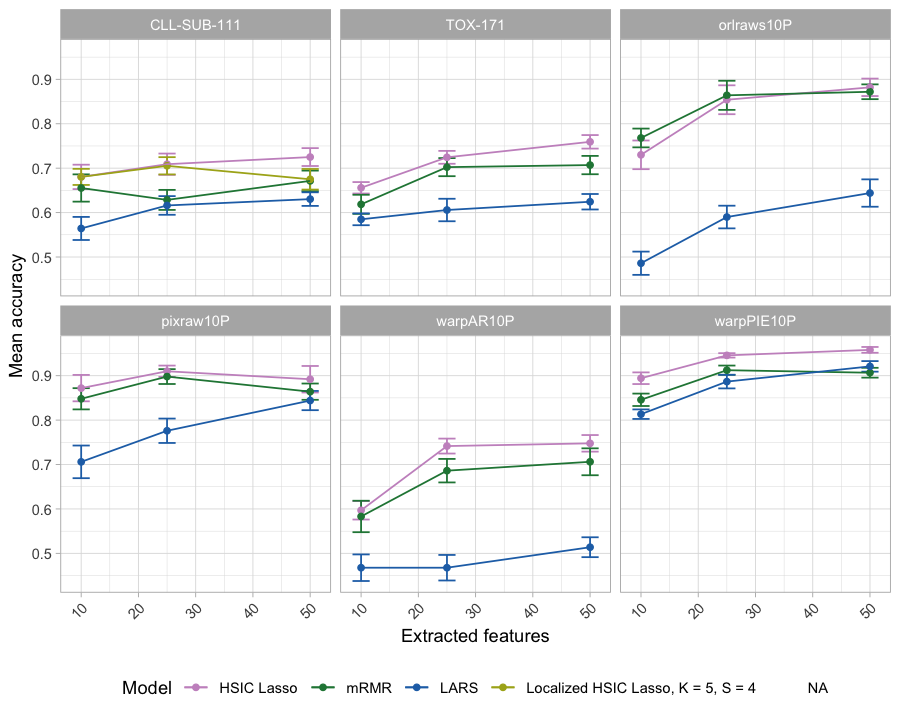

In [153]:
#50 percent + delta decomposition
CLLSUB111 <- summarize_benchmark('../results/others_asu_smalltrain_50p/CLL-SUB-111_prediction.tsv') %>%
    filter(! is.na(model))
pixraw10P <- summarize_benchmark('../results/others_asu_smalltrain_50p/pixraw10P_prediction.tsv') %>%
    filter(! is.na(model))
warpAR10P <- summarize_benchmark('../results/others_asu_smalltrain_50p/warpAR10P_prediction.tsv') %>%
    filter(! is.na(model))
orlraws10P <- summarize_benchmark('../results/others_asu_smalltrain_50p/orlraws10P_prediction.tsv') %>%
    filter(! is.na(model))
warpPIE10P <- summarize_benchmark('../results/others_asu_smalltrain_50p/warpPIE10P_prediction.tsv') %>%
    filter(! is.na(model))
tox171 <- summarize_benchmark('../results/others_asu_smalltrain_50p/TOX-171_prediction.tsv') %>%
    filter(! is.na(model))

CLLSUB111_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p_delta/CLL-SUB-111_prediction.tsv')
tox171_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p_delta/TOX-171_prediction.tsv')
orlraws10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p_delta/orlraws10P_prediction.tsv')
pixraw10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p_delta/pixraw10P_prediction.tsv')
warpAR10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p_delta/warpAR10P_prediction.tsv')
warpPIE10P_lhsic <- summarize_benchmark('../results/lhl_asu_scale_smalltrain_50p_delta/warpPIE10P_prediction.tsv')



CLLSUB111 <- bind_rows(CLLSUB111, CLLSUB111_lhsic)
tox171 <- bind_rows(tox171, tox171_lhsic)
orlraws10P <- bind_rows(orlraws10P, orlraws10P_lhsic)
pixraw10P <- bind_rows(pixraw10P, pixraw10P_lhsic)
warpAR10P <- bind_rows(warpAR10P, warpAR10P_lhsic)
warpPIE10P <- bind_rows(warpPIE10P, warpPIE10P_lhsic)

predictions <- bind_rows(CLLSUB111, pixraw10P, warpAR10P, 
                         orlraws10P, warpPIE10P, tox171) %>%
    mutate(model = factor(model, levels = methods))

options(repr.plot.width=7.5, repr.plot.height=6)
predictions %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        theme_light() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1)) +
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
        scale_color_manual(values = palette) +
        facet_wrap(~label)

In [154]:
CLLSUB111

model,selected,n,ended,sem,accuracy,label
HSIC Lasso,10,10,10,0.02746493,0.6803571,CLL-SUB-111
HSIC Lasso,25,10,10,0.02396526,0.7089286,CLL-SUB-111
HSIC Lasso,50,10,10,0.02013278,0.7250000,CLL-SUB-111
mRMR,10,10,10,0.03070529,0.6553571,CLL-SUB-111
mRMR,25,10,10,0.02255630,0.6285714,CLL-SUB-111
mRMR,50,10,10,0.02308419,0.6714286,CLL-SUB-111
LARS,10,10,10,0.02597312,0.5642857,CLL-SUB-111
LARS,25,10,10,0.02100271,0.6160714,CLL-SUB-111
LARS,50,10,10,0.01530352,0.6303571,CLL-SUB-111
"Localized HSIC Lasso, K = 5, S = 4",10,10,10,0.01814256,0.6803571,CLL-SUB-111


In [46]:
read_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           model = gsub('-B=0', '', model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-M=3', '', model),
           model = factor(model, levels = methods),
           label = label)
}

CLLSUB111 <- read_benchmark('../results/asu/CLL-SUB-111_prediction.tsv')
pixraw10P <- read_benchmark('../results/asu/pixraw10P_prediction.tsv')
warpAR10P <- read_benchmark('../results/asu/warpAR10P_prediction.tsv')
orlraws10P <- read_benchmark('../results/asu/orlraws10P_prediction.tsv')
warpPIE10P <- read_benchmark('../results/asu/warpPIE10P_prediction.tsv')
tox171 <- read_benchmark('../results/asu/TOX-171_prediction.tsv')

predictions <- bind_rows(CLLSUB111, pixraw10P, warpAR10P, 
                         orlraws10P, warpPIE10P, tox171)

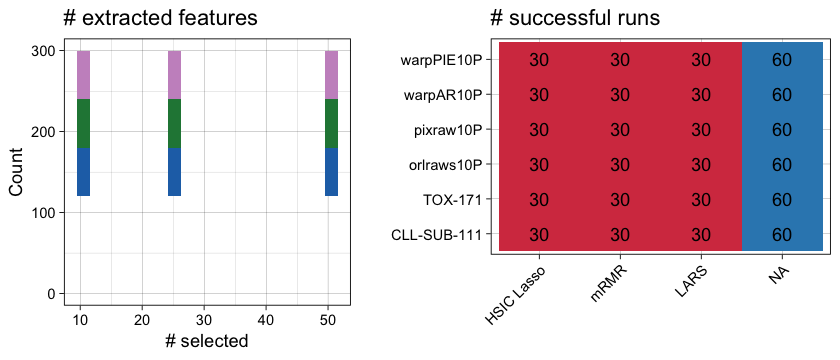

In [39]:
options(repr.plot.width=7, repr.plot.height=3)

selected <- predictions %>%
    ggplot(aes(selected, fill = model)) +
        geom_histogram(bins = 20) +
        theme_linedraw() +
        scale_fill_manual(values = palette) +
        labs(x = '# selected', y = 'Count', fill = 'Method', title = '# extracted features') +
        theme(legend.position = 'none')

finished <- predictions %>%
    group_by(model, label) %>%
    summarize(ended = n()) %>%
    ggplot(aes(x = factor(model), y = factor(label), fill = ended, label = ended)) +
        geom_tile() +
        geom_text() +
        theme_linedraw() +
        theme(legend.position = 'none',
              axis.text.x = element_text(angle = 45, hjust = 1)) +
        labs(x = '', y = '', title = '# successful runs') + 
        scale_fill_distiller(palette = "Spectral", direction = 1)

plot_grid(selected, finished, rel_widths = c(3,4))